## Задание 1

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from sympy import init_printing
from IPython.display import display
init_printing(use_latex='mathjax')

### Пункт 1

In [2]:
mean1 = [0, 0]
mean2 = [3, 3]
cov = [[1, 0], [0, 1]]
x1, y1 = np.random.multivariate_normal(mean1, cov, 500).T
x2, y2 = np.random.multivariate_normal(mean2, cov, 500).T

### Пункт 2

In [3]:
def quadratic_loss_optimization(samples, labels):
    labels = np.asarray(labels)
    np.reshape(labels, (labels.shape[0], 1))
    samples_t = samples.transpose();
    # pseudoinversion in case the matrix here is not invertible 
    return np.linalg.pinv((samples_t @ samples)) @ samples_t @ labels

### Пункт 3

Теперь по сгенерированным данным отобразим на графике оба класса (синий - "1", красный - "-1")

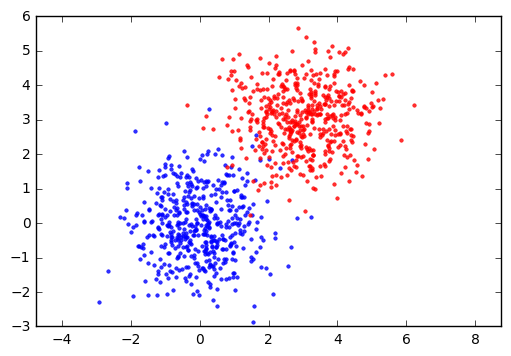

In [4]:
plt.plot(x1, y1, 'b.', x2, y2, 'r.', markersize=5, alpha=0.8)
plt.axis('equal')
plt.show()

### Пункт 4

In [5]:
x1_t = x1.reshape((x1.shape[0], 1))
y1_t = y1.reshape((y1.shape[0], 1))
x2_t = x2.reshape((x2.shape[0], 1))
y2_t = y2.reshape((y2.shape[0], 1))
samples_1 = np.hstack((x1_t, y1_t))
samples_2 = np.hstack((x2_t, y2_t))
labels_1 = np.ones((x1_t.shape[0], 1))
labels_2 = -np.ones((x2_t.shape[0], 1))
samples = np.vstack((samples_1, samples_2))
prepared_samples = np.hstack((samples, np.ones((samples.shape[0], 1))))
labels = np.vstack((labels_1, labels_2))
parameters = quadratic_loss_optimization(prepared_samples, labels)
coefs = parameters[:-1, 0]
shift = parameters[-1, 0]
print(coefs, shift)

[-0.25363043 -0.28528487] 0.803119704786


Простая функция определения класса

In [6]:
def classify(x, coefs, shift):
    if np.dot(x, coefs) + shift >= 0:
        return 1
    else:
        return -1
labeled_samples = np.apply_along_axis(classify, 1, samples, coefs, shift)

samples_x = samples[labeled_samples == 1]
samples_y = samples[labeled_samples == -1]

misses = samples[labeled_samples != labels[:, 0]].shape[0]

Теперь нарисуем на графике прямую, разбивающую точки на классы, и сами классы

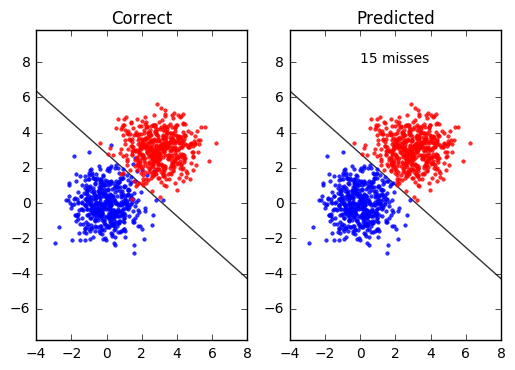

In [8]:
x = [x for x in range(-4, 9)]
y = [-(shift + coefs[0]*i)/coefs[1] for i in x]
plt.subplot(121)
plt.title('Correct')
plt.plot(x, y, 'k-', x1, y1, 'b.', x2, y2, 'r.', markersize=5, alpha=0.8)
plt.axis('equal')
plt.subplot(122)
plt.title('Predicted')
plt.plot(x, y, 'k-', samples_x[:, 0], samples_x[:, 1], 'b.', samples_y[:, 0], samples_y[:, 1],
                                                       'r.', markersize=5, alpha=0.8)
plt.text(0, 8, str(misses) + ' misses')
plt.axis('equal')
plt.show()

#### Отступление
Очевидно, что формулировка метода наименьших квадратов не подразумевает существования некоторого вектора-отступа $b$, который присутствует в нашей задаче. Тем не менее, эта задача сводится к методу наименьших квадратов добавлением в вектор признаков каждого элемента дополнительной компоненты $1$, которая по очевидным причинам не зависит от какого-либо элемента выборки и при скалярном произведении элемента на вектор признаков добавлять константу. В дальнейшем мы будем рассматривать уже модифицированную матрицу признаков и считать ассимптотику для неё.
#### Оценим сложность данного алгоритма
Прежде всего, стоит отметить, что для необратимых матриц $X^TX$ формула $w = (X^TX)^{-1}X^TY$ преобразуется в $w = (X^TX)^+X^TY$, где $M^+$ обозначает псевдообратную матрицу. Грубая оценка сложности алгоритма нахождения псевдообратной квадратной матрицы - $O(n^3)$.

Сложность умножения двух матриц определим, как $O(lmn)$ (для матриц $l \times m$ и $m \times n$).
Мы выполняем следующие операции: перемножение матриц $m \times n$ и $n \times m$, их псевдообращение, перемножение результата с матрицей $m \times n$, перемножение результата с матрицей $n \times 1$. Сложность в таком случае составляет $O(nm^2) + O(m^3) + O(nm^2) + O(nm) = O(nm^2) + O(m^3)$, где $n$ - число элементов в выборке, $m$ - число признаков (с единицей)

### Зависимость Q от M для различных функций потерь

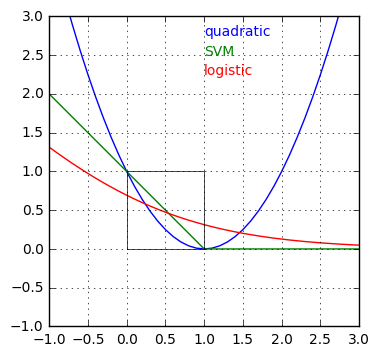

In [27]:
x = [x/10 for x in range(-100, 100)]
m = sympy.symbols('m')
f_quad = sympy.lambdify(m, (m-1)**2)
f_svm = sympy.lambdify(m, sympy.functions.Max(0, 1-m))
f_logistic = sympy.lambdify(m, sympy.log(1 + sympy.exp(-m)))
y_quad = [f_quad(i) for i in x]
y_svm = [f_svm(i) for i in x]
y_logistic = [f_logistic(i) for i in x]

x_box = [0, 1, 1, 0, 0]
y_box = [0, 0, 1, 1, 0]
plt.hold(True)
plt.plot(x, y_quad, 'b-', x, y_svm, 'g-', x, y_logistic, 'r-')
plt.plot(x_box, y_box, 'k-', linewidth=0.5)
plt.hold(False)
plt.axis([-1, 3, -1, 3])
plt.grid()
plt.axes().set_aspect('equal', adjustable='box')
plt.text(1.0, 2.75, 'quadratic', color='blue')
plt.text(1.0, 2.5, 'SVM', color='green')
plt.text(1.0, 2.25, 'logistic', color='red')
plt.show()